# 正则化的多项式逻辑回归

> - 魏宇翔
> - 汪政
> - 冯宇霄
> - 涂欣宇

## 介绍

在这个 notebook 里面，我们调用了我们实现的**正则化的多项式逻辑回归**模型：

- 多元的逻辑回归模型
- 进行二分类任务
- 通过传入参数 `basis function` 实现多项式线性回归
- 引入了正则化，可以通过调整正则化参数 `reg_lambda` 进行实验

我们引用了一组决策边界非线性的数据集来进行实验。

## 实验过程

首先，安装需要的依赖库，并添加 `PYTHONPATH`

In [10]:
!pip install -r ../requirements.txt || pip3 install -r ../requirements.txt

import sys
sys.path.append("..")

Could not build wheels for numpy, since package 'wheel' is not installed.
Could not build wheels for matplotlib, since package 'wheel' is not installed.
Could not build wheels for pandas, since package 'wheel' is not installed.
Could not build wheels for kiwisolver, since package 'wheel' is not installed.
Could not build wheels for pyparsing, since package 'wheel' is not installed.
Could not build wheels for cycler, since package 'wheel' is not installed.
Could not build wheels for python-dateutil, since package 'wheel' is not installed.
Could not build wheels for pytz, since package 'wheel' is not installed.
Could not build wheels for six, since package 'wheel' is not installed.


其次，引入所需要的第三方库以及我们的模型

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from linear_models.binary_classification_model import RegularizedBinaryLogisticRegression

接着，定义我们的数据类型 `Data`。这里的 `basis_func` 是一个 10 次多项式，它包含了所有的 10 次项：

$\phi(x) = \begin{bmatrix}1\\x\\y\\x^2\\y^2\\xy\\\vdots\\x^9y\\x^{10}\end{bmatrix}$

In [12]:
class Data:
    _X = pd.read_csv("../data/ex2data2.txt").values

    # 在第一列补充 1
    X = np.concatenate((np.ones(_X.shape[0]).reshape(-1, 1), _X[:, :-1]), axis=1)
    y = _X[:, -1]

    positive = np.array(list(filter(lambda x: x[2] == 1, _X)))
    negative = np.array(list(filter(lambda x: x[2] == 0, _X)))

    @staticmethod
    def basis_func(x):
        out = [1.0]
        # 多项式的阶数，可以自由修改进行实验
        degree = 10
        for i in range(1, degree + 1):
            for j in range(i + 1):
                out.append((x[1] ** (i - j)) * (x[2] ** j))
        return np.array(out)

接下来初始化模型，这里的梯度

In [13]:
model = RegularizedBinaryLogisticRegression(
    Data.X, Data.y,
    basis_func=Data.basis_func,
    reg_lambda=0
)

print("梯度:", model.gradient())
print("代价:", model.cost())

梯度: [0.01282051 0.037179   0.00150165 0.19227178 0.05395556 0.12758798
 0.06460474 0.05195935 0.05443056 0.07167305 0.18233282 0.02405176
 0.18107167 0.02863798 0.13668543 0.09065897 0.05831464 0.06037869
 0.09669421 0.04518378 0.10202603 0.15631975 0.01914964 0.1787984
 0.01159753 0.16208063 0.01663562 0.1282324  0.09831063 0.05618148
 0.07890107 0.08850433 0.04783366 0.11123899 0.02902849 0.10795675
 0.13024101 0.02236595 0.16662807 0.01344031 0.16250885 0.00659448
 0.13920391 0.00986412 0.11715201 0.09469491 0.05567233 0.09151704
 0.07086649 0.06741377 0.10584253 0.02757826 0.10902135 0.01764278
 0.10494158 0.10855451 0.03018631 0.15540072 0.01461516 0.14995454
 0.01655263 0.1418631  0.00056771 0.12051061 0.00686229 0.10701232]
代价: 0.6931471805599461


定义一个函数，分别画出正类和负类的散点图，以供后面使用

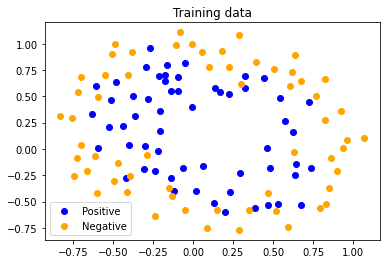

In [14]:
def plot_truth():
    plt.scatter(Data.positive[:, 0], Data.positive[:, 1], color="blue", label="Positive")
    plt.scatter(Data.negative[:, 0], Data.negative[:, 1], color="orange", label="Negative")

plot_truth()
plt.legend()
plt.title("Training data")
plt.show()

定义一个画决策边界的函数，供后续使用

In [15]:
def plot_decision_boundary():
    u = np.linspace(-1, 1.5, 50)
    v = np.linspace(-1, 1.5, 50)

    z = np.zeros((u.size, v.size))
    # Evaluate z = theta*x over the grid
    for i, ui in enumerate(u):
        for j, vj in enumerate(v):
            mapped_value = model.basis_func(np.array([1, ui, vj]))
            std_right_side = (mapped_value[1:] - model.mean) / model.std
            first_column = mapped_value[0]
            mapped_value = np.append(first_column, std_right_side)
            z[i, j] = np.dot(mapped_value, model.params)

    z = z.T

    plt.contour(u, v, z, levels=[0], linewidths=2, colors='r')


使用梯度下降进行训练，首先实现过拟合的情况。画出真实数据以及决策边界，观察到了过拟合现象

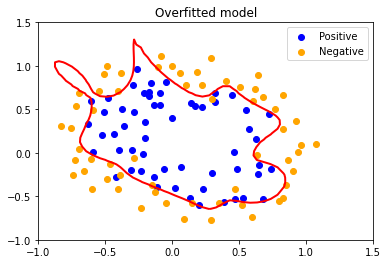

In [16]:
model.params = np.zeros(model.params.size)
model.learn_by_gradient_decent(epochs=50000, learning_rate=3)

plot_truth()
plot_decision_boundary()
plt.legend()
plt.title("Overfitted model")
plt.show()

接下来指定正则化参数 $\lambda = 2$，模型变得更加容易泛化

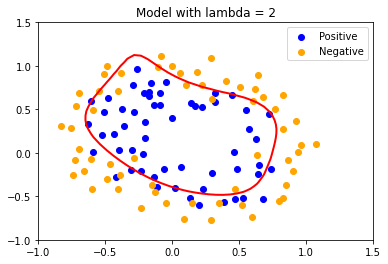

In [17]:
model.params = np.zeros(model.params.size)
model.reg_lambda = 2
model.learn_by_gradient_decent(epochs=50000, learning_rate=3)

plot_truth()
plot_decision_boundary()
plt.legend()
plt.title("Model with lambda = {}".format(model.reg_lambda))
plt.show()

最后，将正则化参数 $\lambda = 25$，模型欠拟合

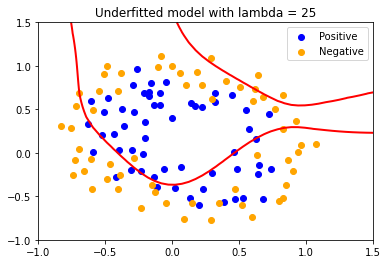

In [18]:
model.params = np.zeros(model.params.size)
model.reg_lambda = 25
model.learn_by_gradient_decent(epochs=50000, learning_rate=3)

plot_truth()
plot_decision_boundary()
plt.legend()
plt.title("Underfitted model with lambda = {}".format(model.reg_lambda))
plt.show()
